In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from gmdh import Combi, Mia

In [4]:
# 1. Загрузка и предобработка
print("1) Загрузка и предобработка данных...")
df = pd.read_csv('dataset/housing_price_dataset.csv')
df = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)
X = df.drop(columns=['Price'])
y = df['Price']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных (48,000 для обучения, ~2,000 для теста)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, train_size=0.96, random_state=42
)
print(f" → Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Подготовка данных для GMDH (немасштабированные для совместимости)
X_train_gmdh, X_test_gmdh, y_train_gmdh, y_test_gmdh = train_test_split(
    X, y, train_size=0.96, random_state=42
)
X_train_np = X_train_gmdh.to_numpy(dtype=float)
X_test_np = X_test_gmdh.to_numpy(dtype=float)
y_train_np = y_train_gmdh.to_numpy(dtype=float).ravel()
y_test_np = y_test_gmdh.to_numpy(dtype=float).ravel()


1) Загрузка и предобработка данных...
 → Train shape: (48000, 6), Test shape: (2000, 6)


In [5]:
# 2. Stacking
print("\n2) Обучение StackingRegressor...")
stack_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
    ],
    final_estimator=LinearRegression()
)
stack_model.fit(X_train, y_train)
print(" ✅ Stacking trained")


2) Обучение StackingRegressor...
 ✅ Stacking trained


In [6]:
# 3. MLP
print("\n3) Обучение MLPRegressor...")
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)
print(" ✅ MLP trained")


3) Обучение MLPRegressor...
 ✅ MLP trained


In [7]:
# 4. GMDH на полной выборке
print("\n4) Обучение GMDH на полной выборке...")
try:
    gmdh_linear = Combi()
    gmdh_linear.fit(X_train_np, y_train_np)
    print(" ✅ GMDH Linear (Combi) trained")
except Exception as e:
    print(f"Ошибка в GMDH Linear (Combi): {e}")
    gmdh_linear = None

try:
    gmdh_nonlinear = Mia()
    gmdh_nonlinear.fit(X_train_np, y_train_np)
    print(" ✅ GMDH Nonlinear (Mia) trained")
except Exception as e:
    print(f"Ошибка в GMDH Nonlinear (Mia): {e}")
    gmdh_nonlinear = None


4) Обучение GMDH на полной выборке...
 ✅ GMDH Linear (Combi) trained
 ✅ GMDH Nonlinear (Mia) trained


In [8]:
# 5. Оценка качества
print("\n5) Оценка качества всех моделей:")
models = {
    'Stacking': (stack_model, X_test, y_test),
    'MLP': (mlp_model, X_test, y_test),
    'GMDH-Linear': (gmdh_linear, X_test_np, y_test_np),
    'GMDH-Nonlinear': (gmdh_nonlinear, X_test_np, y_test_np)
}

results = []
for name, (model, X_eval, y_eval) in models.items():
    if model is None:
        print(f" • {name}: Пропущен из-за ошибки")
        results.append({'Model': name, 'MAE': np.nan, 'R2': np.nan})
        continue
    y_pred = model.predict(X_eval)
    mae = mean_absolute_error(y_eval, y_pred)
    r2 = r2_score(y_eval, y_pred)
    results.append({'Model': name, 'MAE': mae, 'R2': r2})
    print(f" • {name}: MAE = {mae:.2f}, R² = {r2:.4f}")


5) Оценка качества всех моделей:
 • Stacking: MAE = 39656.58, R² = 0.5872
 • MLP: MAE = 39772.36, R² = 0.5867
 • GMDH-Linear: MAE = 39704.93, R² = 0.5874
 • GMDH-Nonlinear: MAE = 39691.25, R² = 0.5873



6) Визуализация результатов...


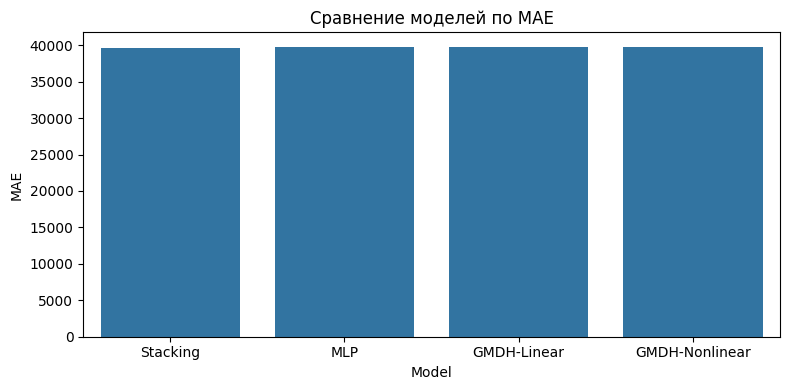

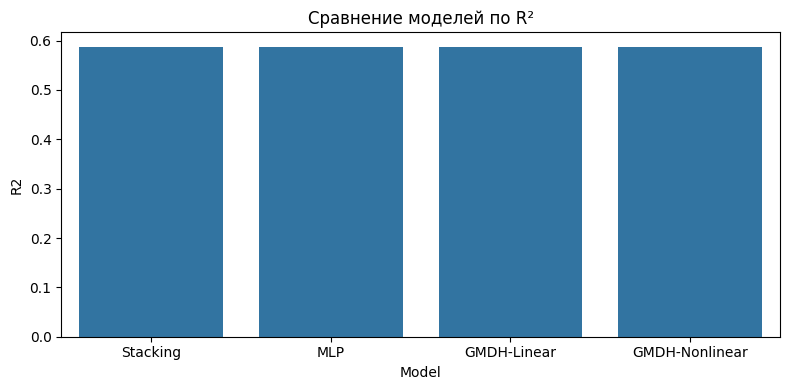

In [10]:
# 6. Визуализация
print("\n6) Визуализация результатов...")
res_df = pd.DataFrame(results)

# График MAE
plt.figure(figsize=(8, 4))
sns.barplot(data=res_df, x='Model', y='MAE')
plt.title('Сравнение моделей по MAE')
plt.tight_layout()
plt.show()

# График R²
plt.figure(figsize=(8, 4))
sns.barplot(data=res_df, x='Model', y='R2')
plt.title('Сравнение моделей по R²')
plt.tight_layout()
plt.show()


7) Визуализация предсказаний (последние 100 домов):


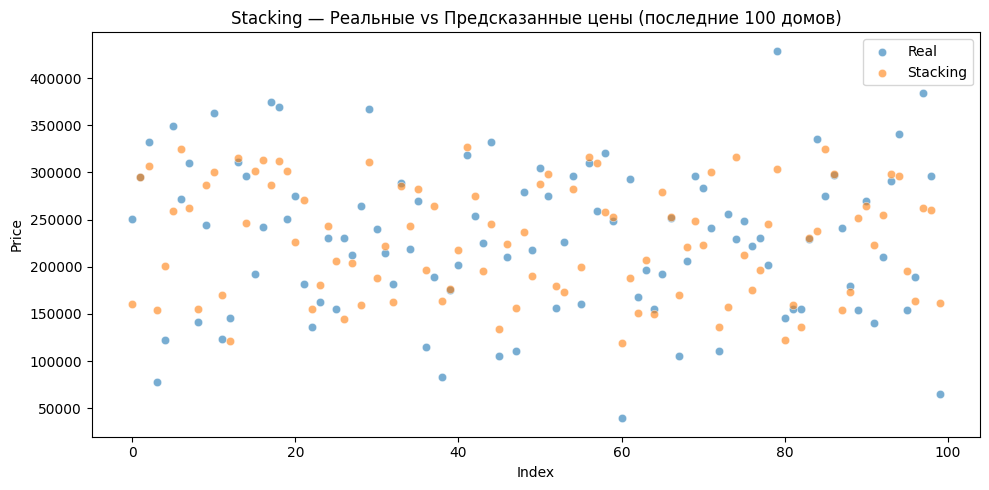

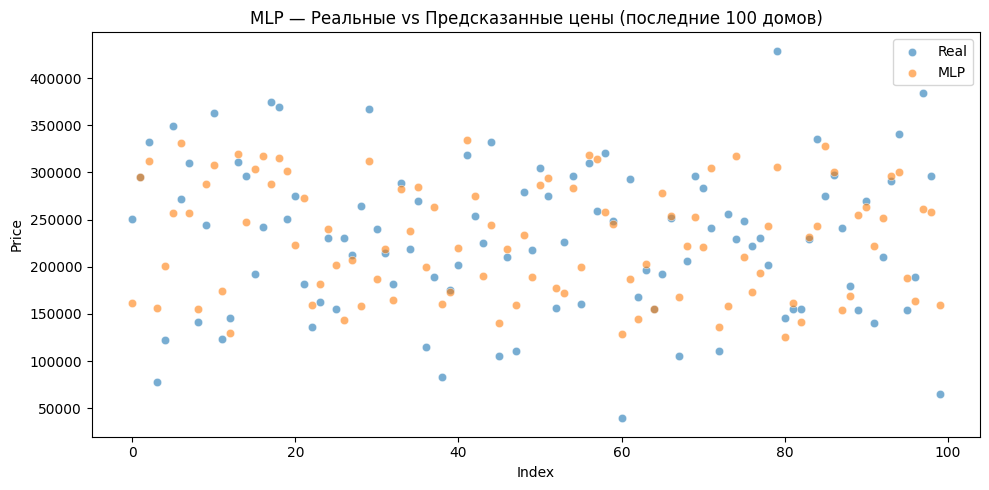

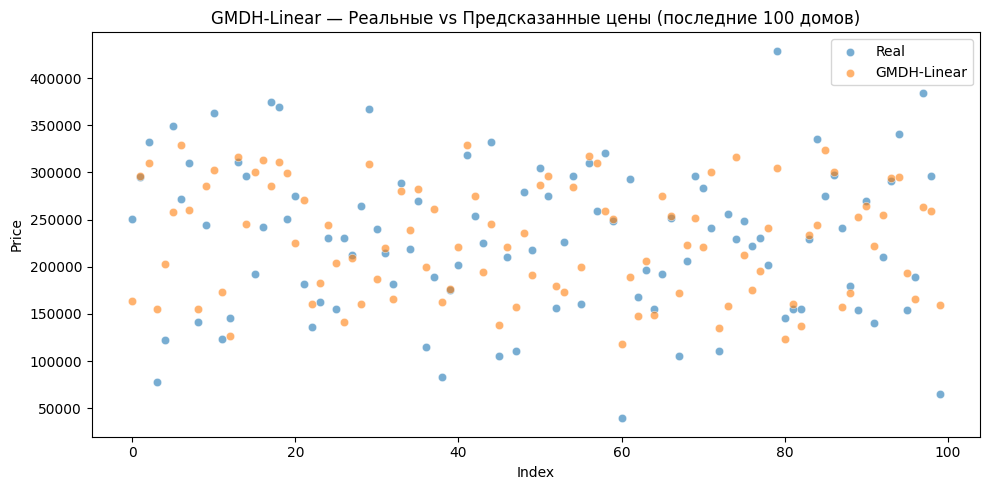

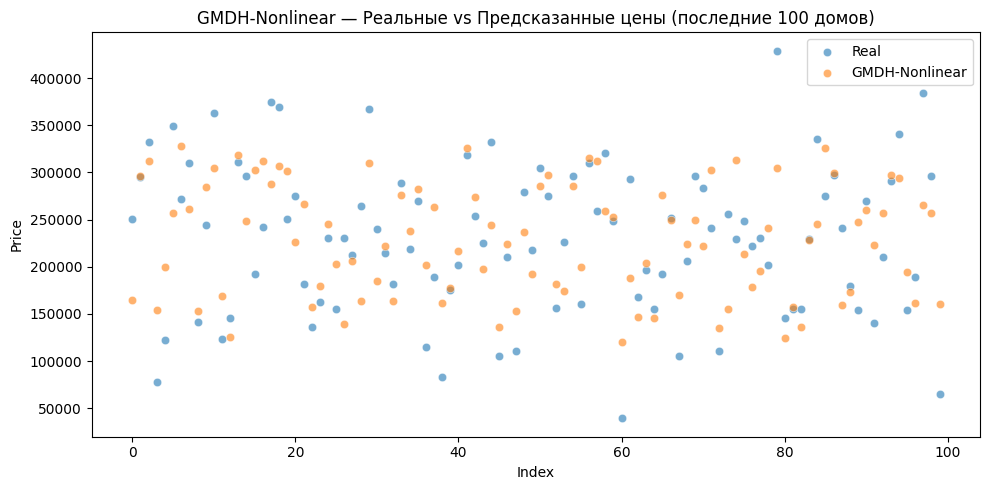


🎉 Скрипт выполнен успешно!


In [11]:
# Scatter-графики предсказаний (последние 100 домов)
print("\n7) Визуализация предсказаний (последние 100 домов):")
for name, (model, X_eval, y_eval) in models.items():
    if model is None:
        print(f" • {name}: Пропущен из-за ошибки")
        continue
    y_pred = model.predict(X_eval)
    # Выбираем последние 100 примеров
    y_eval_last = y_eval[-100:]
    y_pred_last = y_pred[-100:]
    vis_df = pd.DataFrame({
        'Index': np.arange(100),
        'True': y_eval_last,
        'Pred': y_pred_last
    })
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=vis_df, x='Index', y='True', label='Real', alpha=0.6)
    sns.scatterplot(data=vis_df, x='Index', y='Pred', label=name, alpha=0.6)
    plt.title(f'{name} — Реальные vs Предсказанные цены (последние 100 домов)')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n🎉 Скрипт выполнен успешно!")